### Train a BERT Classifier 
Code is based on https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb and https://github.com/reascr/MA_Speech_and_Language_Processing/blob/main/Deep_Learning_with_Python/DeepLearning2022-Project.ipynb (De Rosa Palmini & Schröter 2022).

In [1]:
#pip install -U sentence-transformers
from transformers import BertTokenizer
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [2]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes-bal/train_bal.csv')
df_val = pd.read_csv('/kaggle/input/dataframes-bal/val_bal.csv')
df_test = pd.read_csv('/kaggle/input/dataframes-bal/test_bal.csv')
df_train.head()

,IMAGE_FILE,DESCRIPTION,AUTHOR,comment_length
0,16346-virtu_4.jpg,The figures of Justice and Injustice are large...,GIOTTO di Bondone,348
1,16980-2hague03.jpg,"Catalogue numbers: F 4, JH 187.In the years 18...","GOGH, Vincent van",314
2,33896-11noremb.jpg,Catalogue number: Bredius 109.[PAINTER]'s life...,REMBRANDT Harmenszoon van Rijn,624
3,35604-06landsc.jpg,Saint George and the Dragon symbolises the clo...,"RUBENS, Peter Paul",2685
4,39730-6perseus.jpg,This painting is one of the six 'poesie' paint...,TIZIANO Vecellio,81


In [3]:
max_length = 512

# Prepare input data
input_ids_train = np.zeros((len(df_train), max_length))
att_masks_train = np.zeros((len(df_train), max_length))

input_ids_val = np.zeros((len(df_val), max_length))
att_masks_val = np.zeros((len(df_val), max_length))

input_ids_test = np.zeros((len(df_test), max_length))
att_masks_test = np.zeros((len(df_test), max_length))


def encode_text(df, ids, attention_masks, tokenizer):
    '''
    This function iterates over all rows in a dataframe. Using the encode_plus() method of the Tokenizer object,
    it encodes the text data and stores the ids and attention masks in numpy arrays. The tqdm function is used to display a progress bar.
    '''
    for i, text in tqdm(enumerate(df['DESCRIPTION'])):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=512,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized.input_ids
        attention_masks[i, :] = tokenized.attention_mask
    return ids, attention_masks

# fill the numpy arrays inititalized with zeros with the input ids and attention masks for the dataset

# encode train data
input_ids_train, att_masks_train = encode_text(df_train, input_ids_train, att_masks_train, tokenizer)

# encode validation data
input_ids_val, att_masks_val = encode_text(df_val, input_ids_val, att_masks_val, tokenizer)

# encode test data
input_ids_test, att_masks_test = encode_text(df_test, input_ids_test, att_masks_test, tokenizer)


0it [00:00, ?it/s]2024-05-22 17:46:26.450283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 17:46:26.450328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 17:46:26.451910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
1602it [00:07, 204.19it/s]
89it [00:00, 359.99it/s]
89it [00:00, 361.68it/s]


In [4]:
# prepare labels
from keras.utils import to_categorical

label_encoder = LabelEncoder()

# apply label encoder to transform labels into integers
labels_train = label_encoder.fit_transform(df_train['AUTHOR'])
labels_val = label_encoder.transform(df_val['AUTHOR'])
labels_test = label_encoder.transform(df_test['AUTHOR'])

labels_train = to_categorical(np.asarray(labels_train))
labels_val = to_categorical(np.asarray(labels_val))
labels_test = to_categorical(np.asarray(labels_test))

painter_mapping = list(label_encoder.classes_) # get new label numbers and painters (for confusion matrix legend)
print(painter_mapping)

['CRANACH, Lucas the Elder', 'GIOTTO di Bondone', 'GOGH, Vincent van', 'GRECO, El', 'REMBRANDT Harmenszoon van Rijn', 'RUBENS, Peter Paul', 'TIEPOLO, Giovanni Battista', 'TIZIANO Vecellio', 'UNKNOWN MASTER, Italian', 'VERONESE, Paolo']


In [5]:
import tensorflow as tf
# create a data pipeline for feeding the encoded input sequences, attention masks and label data into the model
train_dataset = tf.data.Dataset.from_tensor_slices((input_ids_train, att_masks_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((input_ids_val, att_masks_val, labels_val))
test_dataset = tf.data.Dataset.from_tensor_slices((input_ids_test, att_masks_test, labels_test))
train_dataset.take(1) # retrieve first sample in data set and check its shape and content

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [6]:
# creating dictionaries
def SentimentDatasetMapFunction(input_ids, att_masks, labels):
    '''This function maps the encoded input sequences, attention masks and labels to a format required by the input layer of the BERT model.
    It returns a dictionary with two keys (input_ids and attention_mask) that can be later used as input to the map method of a tf.data.Dataset object.'''
    return {
        'input_ids': input_ids,
        'attention_mask': att_masks
    }, labels

In [7]:
# transform data according to the SentimentDataSetMapfunction (required format for tensorflow dataset)
#converting to required format for tensorflow dataset
# Map datasets
train_dataset = train_dataset.map(SentimentDatasetMapFunction)
val_dataset = val_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
train_dataset.take(0)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [8]:
batch_size=64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [9]:
train_dataset = train_dataset.map(lambda x, y: ({'input_ids': tf.cast(x['input_ids'], tf.int32), 'attention_mask': tf.cast(x['attention_mask'], tf.int32)}, y))
val_dataset = val_dataset.map(lambda x, y: ({'input_ids': tf.cast(x['input_ids'], tf.int32), 'attention_mask': tf.cast(x['attention_mask'], tf.int32)}, y))
test_dataset = test_dataset.map(lambda x, y: ({'input_ids': tf.cast(x['input_ids'], tf.int32), 'attention_mask': tf.cast(x['attention_mask'], tf.int32)}, y))

In [10]:
# loading the bert-uncased model
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
# freeze weights of BERT's layers (prevent weights from pre-trained BERT model from updating)
bert = model.bert

for layer in bert.submodules:
    layer.trainable = False

In [12]:
# Set random seeds for reproducibility TRY TEN DIFFERENT PER MODEL
# np.random.seed(42)
#tf.random.set_seed(42)

# defining the two input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
att_masks = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=att_masks)[1] # getting the pooled output layer

intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(intermediate_layer)

bert_model = tf.keras.Model(inputs=[input_ids, att_masks], outputs=output_layer)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [14]:
bert_model.compile(optimizer=optim, loss=loss_func, metrics=['acc'])

In [15]:
# train model
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15 # change to 20 later
)

Epoch 1/15


I0000 00:00:1716400068.874350     787 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 132s 3s/step - loss: 2.2920 - acc: 0.1411 - val_loss: 2.2225 - val_acc: 0.1348
Epoch 2/15
26/26 [==============================] - 76s 3s/step - loss: 2.2212 - acc: 0.1804 - val_loss: 2.1862 - val_acc: 0.1798
Epoch 3/15
26/26 [==============================] - 76s 3s/step - loss: 2.1737 - acc: 0.1866 - val_loss: 2.1764 - val_acc: 0.1910
Epoch 4/15
26/26 [==============================] - 76s 3s/step - loss: 2.1415 - acc: 0.2197 - val_loss: 2.1317 - val_acc: 0.2022
Epoch 5/15
26/26 [==============================] - 76s 3s/step - loss: 2.1109 - acc: 0.2441 - val_loss: 2.1140 - val_acc: 0.2921
Epoch 6/15
26/26 [==============================] - 76s 3s/step - loss: 2.0794 - acc: 0.2416 - val_loss: 2.0926 - val_acc: 0.2584
Epoch 7/15
26/26 [==============================] - 76s 3s/step - loss: 2.0663 - acc: 0.2559 - val_loss: 2.0614 - val_acc: 0.2921
Epoch 8/15
26/26 [==============================] - 76s 3s/step - loss: 2.0493 - acc: 0.2622 - val_l

In [16]:
# evaluate model on test data
test_loss, test_acc = bert_model.evaluate(test_dataset, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 1.8164058923721313
Test accuracy: 0.4157303273677826


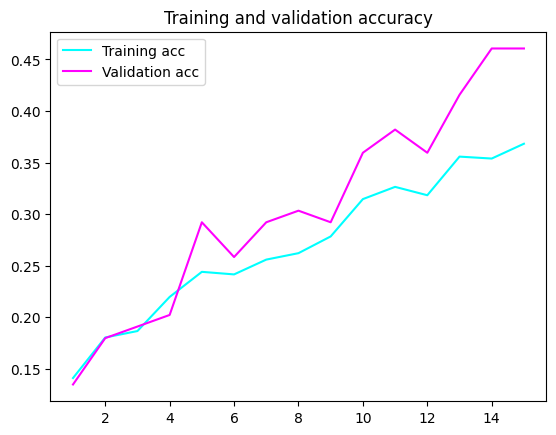

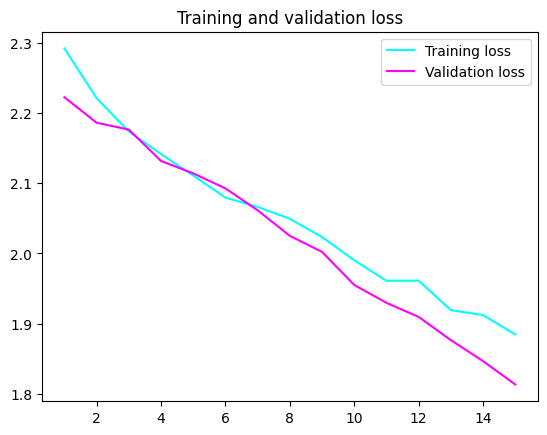

In [17]:
# plotting the accuracy and loss of the training and validation data for the BERT model (cf. Chollet 2018: 192)

# plot training and validation accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
'''# confusion matrix 

# predictions on test set
y_pred = model.predict(test_dataset, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(labels_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()'''

In [21]:
'''# code from https://www.intodeeplearning.com/bert-multiclass-text-classification/#Error-Analysis, retrieved May 22, 2024.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()
    
y_pred = model.predict(test_dataset, batch_size=64, verbose=1)
plot_confusion_matrix(y_pred,labels_test,labels=painter_mapping)'''

'# code from https://www.intodeeplearning.com/bert-multiclass-text-classification/#Error-Analysis, retrieved May 22, 2024.\nfrom sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix\n\ndef plot_confusion_matrix(y_preds, y_true, labels=None):\n  cm = confusion_matrix(y_true, y_preds, normalize="true")\n  fig, ax = plt.subplots(figsize=(6, 6))\n  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) \n  disp.plot(cmap="BuPu", values_format=".2f", ax=ax, colorbar=False) \n  plt.title("Normalized confusion matrix")\n  plt.show()\n    \ny_pred = model.predict(test_dataset, batch_size=64, verbose=1)\nplot_confusion_matrix(y_pred,labels_test,labels=painter_mapping)'

### Now use a very similar architecture to the other baseline (visual features only), add Dropout regularization, Batch Normalization, and early stopping (and use same random seed = 42): 
# TO DO: change model architecture so it's more similar to the other baseline

In [ ]:
# Set random seeds for reproducibility: TRY TEN DIFFERENT PER MODEL
# np.random.seed(42)
tf.random.set_seed(42)

# defining the two input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
att_masks = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=att_masks)[1] # getting the pooled output layer

intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(intermediate_layer)

bert_model = tf.keras.Model(inputs=[input_ids, att_masks], outputs=output_layer)

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
bert_model.summary()

bert_model.compile(optimizer=optim, loss=loss_func, metrics=['acc'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# train model
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20, callbacks=[early_stopping]
)

In [ ]:
# evaluate model on test data
test_loss, test_acc = bert_model.evaluate(test_dataset, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
# plotting the accuracy and loss of the training and validation data for the BERT model (cf. Chollet 2018: 192)

# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# confusion matrix 

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()